In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL


TIERS = {
    "ShortGap": (1, 6),
    "MediumGap": (7, 24),
    "WeekGap": (25, 168),
    "LongGap": (169, np.inf),
}

In [16]:
def load_and_index_csv(file_path: str) -> pd.DataFrame:
    """
    Load a CSV file with a timestamp column, rename and index by datetime.

    Parameters
    ----------
    file_path : str
        Path to the CSV file. The first column is assumed to be the timestamp.

    Returns
    -------
    pd.DataFrame
        DataFrame indexed by a timezone-aware hourly datetime index, sorted ascending.

    Usage
    -----
    >>> df = load_and_index_csv("electricity_cleaned.csv")
    """
    df = pd.read_csv(file_path)
    # Rename first column to 'timestamp'
    df.rename(columns={df.columns[0]: "timestamp"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    df = df.set_index("timestamp").sort_index()
    # Enforce hourly frequency
    df = df.asfreq('H')
    return df

In [17]:
def missing_value_summary(df: pd.DataFrame) -> pd.Series:
    """
    Compute percentage of missing values per column and overall.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with a datetime index.

    Returns
    -------
    pd.Series
        Series of percentage missing per column, sorted descending.

    Usage
    -----
    >>> na_pct = missing_value_summary(df)
    >>> print(f"Overall missing rate: {df.isna().values.mean()*100:.2f}%")
    """
    na_pct = df.isna().mean().sort_values(ascending=False) * 100
    na_pct.name = "% NaNs"
    return na_pct

In [18]:
def find_nan_blocks(series: pd.Series) -> pd.DataFrame:
    """
    Identify runs of consecutive NaNs in a Series.

    Parameters
    ----------
    series : pd.Series
        Time-indexed series (must be sorted ascending).

    Returns
    -------
    pd.DataFrame
        DataFrame with ['start', 'end', 'length'] of each NaN block.
    """
    series = series.sort_index()  # fix: ensure chronological order

    is_nan = series.isna()
    # Find changes: False → True (start), True → False (end)
    change = is_nan.ne(is_nan.shift()).cumsum()
    groups = is_nan.groupby(change)

    records = []
    for k, v in groups:
        if v.iloc[0]:  # Only process NaN groups
            records.append({
                "start": v.index[0],
                "end":   v.index[-1],
                "length": len(v)
            })

    return pd.DataFrame(records, columns=["start", "end", "length"]).sort_values("start")

In [19]:
def gap_lengths(series):
    """Return list of consecutive-NaN run lengths for one series."""
    is_nan = series.isna()
    return is_nan.groupby((~is_nan).cumsum()).sum().loc[lambda x: x.gt(0)].tolist()

In [20]:
def gap_lengths_summary(df: pd.DataFrame) -> pd.Series:
    """
    Flatten all consecutive NaN gap lengths across a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with time-indexed columns.

    Returns
    -------
    pd.Series
        Series of gap lengths (in number of time steps), across all columns.
    """
    gap_lists = df.apply(gap_lengths)  # Series of lists
    flat_list = [length for sublist in gap_lists for length in sublist]
    return pd.Series(flat_list, name="gap_length")

In [21]:
def gap_length_distribution(df: pd.DataFrame) -> pd.Series:
    """
    Flatten out ALL NaN-block lengths across every column into one Series.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame with NaNs marking missing values.

    Returns
    -------
    pd.Series
        One long Series of integer gap lengths. Columns with no NaNs simply
        contribute zero entries rather than failing.
    """
    all_lengths = []
    for col in df.columns:
        blocks = find_nan_blocks(df[col])
        if not blocks.empty:
            all_lengths.extend(blocks["length"].tolist())
    return pd.Series(all_lengths, name="gap_length")

In [22]:
def drop_high_na_columns(df: pd.DataFrame, threshold: float = 0.80) -> pd.DataFrame:
    """
    Drop columns exceeding a missing-value threshold.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    threshold : float, optional
        Fraction of allowed missing values (0–1). Columns with higher missingness are dropped.

    Returns
    -------
    pd.DataFrame
        DataFrame with high-NA columns removed.

    Usage
    -----
    >>> df_clean = drop_high_na_columns(df, threshold=0.80)
    """
    na_frac = df.isna().mean()
    high_na = na_frac[na_frac > threshold].index.tolist()
    if high_na:
        df = df.drop(columns=high_na)
    print(f"Dropped {len(high_na)} columns with >{threshold:.0%} missing values: {high_na}")
    return df

In [23]:
def summarize_gap_lengths(blocks_df: pd.DataFrame) -> pd.Series:
    """
    Compute descriptive statistics for gap lengths in a block DataFrame.

    Parameters
    ----------
    blocks_df : pd.DataFrame
        Output of find_nan_blocks(). Must contain a 'length' column.

    Returns
    -------
    pd.Series
        Descriptive statistics: count, mean, std, min, percentiles, max, mode.
    """
    if blocks_df.empty:
        return pd.Series(dtype="float64", name="gap_length_summary")
    
    desc = blocks_df["length"].describe(percentiles=[.25, .5, .75, .9])
    mode_val = blocks_df["length"].mode()
    if not mode_val.empty:
        desc["mode"] = mode_val.iloc[0]
    else:
        desc["mode"] = np.nan
    return desc

In [24]:
def compute_tier_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute summary statistics (count, mean, median, etc.) of gap lengths
    across all columns, bucketed by tier.

    Parameters
    ----------
    df : pd.DataFrame
        Time-indexed DataFrame with possible NaNs.

    Returns
    -------
    pd.DataFrame
        Tier-level summary: one row per tier, columns include count, mean, median, etc.
    """
    all_lengths = {tier: [] for tier in TIERS}

    for col in df.columns:
        blocks = find_nan_blocks(df[col])
        if blocks.empty:
            continue
        for length in blocks["length"]:
            for tier, (lo, hi) in TIERS.items():
                if lo <= length <= hi:
                    all_lengths[tier].append(length)
                    break

    # Compute summary stats per tier
    tier_stats = {}
    for tier, lengths in all_lengths.items():
        if lengths:
            s = pd.Series(lengths)
            stats_row = s.describe(percentiles=[.25, .5, .75, .9]).to_dict()
            stats_row["mode"] = s.mode().iloc[0] if not s.mode().empty else np.nan
            tier_stats[tier] = stats_row
        else:
            tier_stats[tier] = {k: np.nan for k in ["count", "mean", "std", "min", "25%", "50%", "75%", "90%", "max", "mode"]}

    return pd.DataFrame(tier_stats).T

In [25]:
def summarize_gaps_all_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a table of gap-length summary statistics per column.

    Parameters
    ----------
    df : pd.DataFrame
        Time-indexed DataFrame with NaNs.

    Returns
    -------
    pd.DataFrame
        Each row corresponds to a column from df.
        Columns include count, mean, median, std, percentiles, max, and mode of gap lengths.
    """
    summary_rows = {}

    for col in df.columns:
        blocks = find_nan_blocks(df[col])
        if blocks.empty:
            continue
        lengths = blocks["length"]
        stats = lengths.describe(percentiles=[.25, .5, .75, .9]).to_dict()
        stats["mode"] = lengths.mode().iloc[0] if not lengths.mode().empty else np.nan
        summary_rows[col] = stats

    return pd.DataFrame.from_dict(summary_rows, orient='index')

In [26]:
# Load the data
df = load_and_index_csv("electricity_cleaned.csv")

# Display missing value summary before dropping
na_before_summary = missing_value_summary(df)
print(f"Overall missing rate: {df.isna().values.mean() * 100:.2f}%")

# Get Gap Length summary before dropping
gap_summ_before_dropping = gap_lengths_summary(df)
print("\n--- Gap length stats BEFORE dropping columns ---")
print(gap_summ_before_dropping.describe(percentiles=[.25, .5, .75, .9]))

# Drop columns with high missing value rates
df_cleaned = drop_high_na_columns(df, threshold=0.80)

# Get Gap Length Summary after dropping
gap_summ_after_dropping = gap_lengths_summary(df_cleaned)
print("\n--- Gap length stats AFTER dropping columns ---")
print(gap_summ_after_dropping.describe(percentiles=[.25, .5, .75, .9]))

# Display missing value summary before dropping
na_after_summary = missing_value_summary(df)
print(f"Overall missing rate: {df.isna().values.mean() * 100:.2f}%")

# Create tiered gap length statistics
tier_stats = compute_tier_stats(df_cleaned)
print("\n--- Tiered gap length statistics ---")
print(tier_stats)

# Visualize statistics for all columns
gap_summary = summarize_gaps_all_columns(df_cleaned)
print("\n--- Gap length summary for all columns ---")
print(gap_summary.head(5))

Overall missing rate: 8.93%

--- Gap length stats BEFORE dropping columns ---
count    47738.000000
mean        51.779568
std        553.881986
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
90%         24.000000
max      17544.000000
Name: gap_length, dtype: float64
Dropped 25 columns with >80% missing values: ['Rat_education_Chance', 'Rat_public_Ulysses', 'Rat_education_Mac', 'Rat_education_Kristie', 'Rat_education_Angelica', 'Lamb_education_Renae', 'Lamb_office_Joanna', 'Peacock_public_Linda', 'Gator_assembly_Elliot', 'Gator_assembly_Hue', 'Bobcat_education_Seth', 'Bobcat_public_Angie', 'Bobcat_education_Emile', 'Bobcat_education_Barbra', 'Bobcat_warehouse_Charlie', 'Hog_office_Judith', 'Hog_assembly_Marilynn', 'Hog_assembly_Annemarie', 'Hog_parking_Joan', 'Hog_assembly_Una', 'Hog_assembly_Arlie', 'Eagle_assembly_Noel', 'Eagle_lodging_Garland', 'Cockatoo_assembly_Britt', 'Cockatoo_education_Latrice']

--- Gap length stats AFTER dropping colum

In [27]:
def kalman_smoother_impute(series: pd.Series) -> pd.Series:
    """
    Impute missing values in a univariate time series using a Kalman smoother
    with an AR(1) state-space model.

    Parameters
    ----------
    series : pd.Series
        Time-indexed series possibly containing NaNs.

    Returns
    -------
    pd.Series
        Series of same length/index with NaNs filled by Kalman-smoothed estimates.

    Usage
    -----
    >>> filled = kalman_smoother_impute(df['Building_A'])
    """
    # Ensure chronological order and frequency
    series = series.sort_index().asfreq('H')

    # Define and fit AR(1) state-space model
    model = SARIMAX(series, order=(1, 0, 0), initialization='approximate_diffuse')
    fitted = model.fit(disp=False)

    # Predict values across full index and combine
    predicted = fitted.predict(start=series.index[0], end=series.index[-1])
    return series.combine_first(predicted)

In [28]:
def na_seadec_impute(series: pd.Series,
                     period: int = 24,
                     robust: bool = True) -> pd.Series:
    """
    Impute missing values via Kalman-prefill + seasonal decomposition + residual interpolation.

    Steps:
      1. Sort & enforce hourly frequency.
      2. Prefill NaNs with Kalman smoother (AR(1) state-space).
      3. Apply STL to the Kalman-prefilled series.
      4. Interpolate the STL residuals.
      5. Reconstruct only at original NaN positions.

    Parameters
    ----------
    series : pd.Series
        Hourly-indexed series possibly containing NaNs.
    period : int, default 24
        Seasonal period (hours).
    robust : bool, default True
        Whether to use robust fitting in STL.

    Returns
    -------
    pd.Series
        Series of same length/index with NaNs imputed by STL + Kalman prefill.
    """
    # 1. Sort and enforce frequency
    s = series.sort_index().asfreq('H')

    # 2. Prefill via Kalman smoother
    prefilled = kalman_smoother_impute(s)

    # 3. Decompose the prefilled series
    stl = STL(prefilled, period=period, robust=robust)
    res = stl.fit()
    trend, seasonal = res.trend, res.seasonal

    # 4. Compute and interpolate residuals
    resid = prefilled - trend - seasonal
    resid_interp = resid.interpolate(method='time')

    # 5. Reconstruct ONLY at original NaNs
    filled = prefilled.copy()
    mask = s.isna()
    reconstruction = trend + seasonal + resid_interp
    filled.loc[mask] = reconstruction.loc[mask]

    return filled
    return pd.Series(filled, index=series.index)

In [ ]:
from tqdm.auto import tqdm

def gap_based_impute_all(df: pd.DataFrame,
                         max_kalman_gap: int = 24,
                         period: int = 24) -> pd.DataFrame:
    """
    Impute missing values in a DataFrame using:
      - Kalman smoother for gaps <= `max_kalman_gap` hours.
      - STL-based seasonal decomposition for all longer gaps.

    Parameters
    ----------
    df : pd.DataFrame
        Hourly-indexed DataFrame containing NaNs.
    max_kalman_gap : int, default 24
        Gaps of length <= this (hours) are filled by Kalman smoother.
        Longer gaps will be filled by STL-based seasonal decomposition.
    period : int, default 24
        Seasonal period (hours) for STL decomposition.

    Returns
    -------
    pd.DataFrame
        Copy of `df` with all NaNs imputed (using Kalman or STL).
    """
    df_out = df.copy()

    for col in df_out.columns:
        series = df_out[col]

        if series.isna().sum() == 0:
            continue  # Skip fully observed series

        blocks = find_nan_blocks(series)
        print(f"\nImputing column '{col}' with {len(blocks)} NaN blocks")
        print(blocks)

        if blocks.empty:
            continue

        # Precompute full imputations
        k_full = kalman_smoother_impute(series).reindex(series.index)
        s_full = na_seadec_impute(series, period=period).reindex(series.index)

        for _, row in tqdm(blocks.iterrows(), total=len(blocks), desc=f"Imputing {col}"):
            start, end, length = row["start"], row["end"], row["length"]

            if length <= max_kalman_gap:
                df_out.loc[start:end, col] = k_full.loc[start:end]
            else:
                seg = s_full.loc[start:end]
                if seg.notna().sum() > 0:
                    df_out.loc[start:end, col] = seg

    return df_out

# Impute short and long gaps using the updated rules
df_imputed = gap_based_impute_all(df_cleaned, max_kalman_gap=24)

# Summary after imputation
na_imputed_summary = missing_value_summary(df_imputed)
print(f"Overall missing rate after imputation: {df_imputed.isna().values.mean() * 100:.2f}%")

# Show head
print("\n--- Imputed DataFrame Head ---")
print(df_imputed.head())

In [30]:
import matplotlib.pyplot as plt

def plot_imputation_sources(original_df: pd.DataFrame,
                            imputed_df: pd.DataFrame,
                            short_thresh: int = 6,
                            medium_thresh: int = 24,
                            period: int = 24,
                            colname: str | None = None,
                            figsize=(16, 6)) -> None:
    """
    Plot original and imputed time series, highlighting which method imputed each gap.

    Parameters
    ----------
    original_df : pd.DataFrame
        DataFrame with NaNs marking gaps.
    imputed_df : pd.DataFrame
        Result from `gap_based_impute_with_tier3`, or equivalent.
    short_thresh : int, default 6
        Max length for Kalman smoothing (short gaps).
    medium_thresh : int, default 24
        Max length for seasonal decomposition (medium gaps).
    period : int, default 24
        Seasonal period for STL decomposition.
    colname : str, optional
        Column to visualize. Defaults to the first column.
    figsize : tuple, default (16, 6)
        Size of the resulting figure.

    Returns
    -------
    None
        Displays the plot with original and imputed series.
    """
    if colname is None:
        colname = original_df.columns[0]

    original = original_df[colname]
    imputed = imputed_df[colname]

    kalman = kalman_smoother_impute(original)
    seadec = na_seadec_impute(original, period)

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
    axes[0].set_title("Original Series with NaNs")
    axes[0].plot(original.index, original.values, label="Original", color="grey")

    axes[1].set_title("Imputed Series with Sources")
    axes[1].plot(imputed.index, imputed.values, label="Imputed", color="grey")

    blocks = find_nan_blocks(original)
    for _, row in blocks.iterrows():
        start, end, length = row["start"], row["end"], row["length"]

        # ORIGINAL PLOT: show short/medium gaps
        if length <= short_thresh:
            axes[0].axvspan(start, end, color="blue", alpha=0.2,
                            label="Short gap" if "Short gap" not in axes[0].get_legend_handles_labels()[1] else "")
        elif length <= medium_thresh:
            axes[0].axvspan(start, end, color="green", alpha=0.2,
                            label="Medium gap" if "Medium gap" not in axes[0].get_legend_handles_labels()[1] else "")


        # IMPUTED PLOT: show source of imputation
        if length <= short_thresh:
            axes[1].plot(original.loc[start:end].index,
                         kalman.loc[start:end].values,
                         color="blue", linestyle="dashed", alpha = 0.7,
                         label="Kalman Smoother" if "Kalman Smoother" not in axes[1].get_legend_handles_labels()[1] else "")
        elif length <= medium_thresh:
            axes[1].plot(original.loc[start:end].index,
                         seadec.loc[start:end].values,
                         color="green", linestyle="dotted", alpaha=0.7,
                         label="Seasonal Decomp." if "Seasonal Decomp." not in axes[1].get_legend_handles_labels()[1] else "")

    for ax in axes:
        ax.legend()
        ax.grid(True)
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Value")

    plt.tight_layout()
    plt.show()



--- Gap length summary after imputation ---
count     30833
unique       53
top           _
freq       3106
Name: gap_length, dtype: object


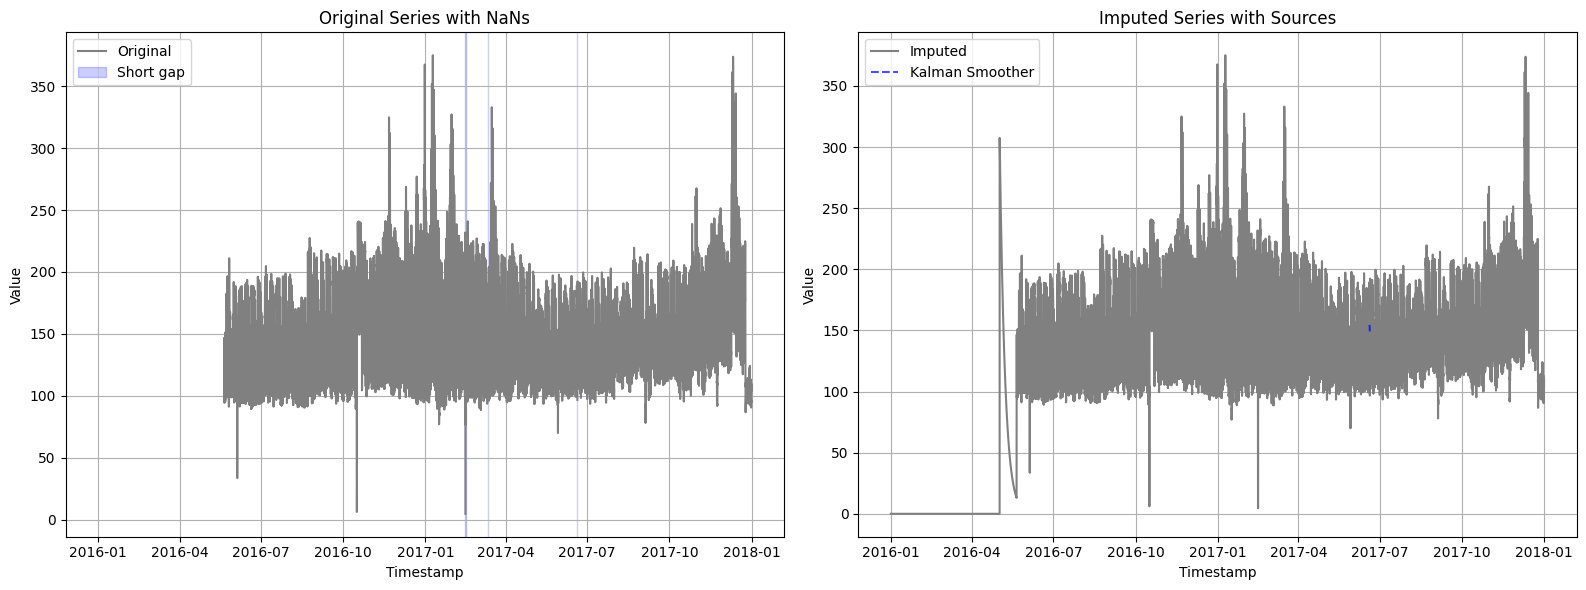

In [31]:
# Get Gap Length Summary after imputation
imputed_gap_stats = gap_lengths_summary(df_imputed)
print("\n--- Gap length summary after imputation ---")
print(imputed_gap_stats.describe(percentiles=[.25, .5, .75, .9]))

# Plot imputation sources for the first column
plot_imputation_sources(df_cleaned, df_imputed, colname=df_cleaned.columns[4])

In [32]:
# Save df_imputed to a CSV file
df_imputed.to_csv("imputed_data.csv", index=False)

print("Data saved as 'imputed_data.csv'")


Data saved as 'imputed_data.csv'
